In [12]:
import sys
sys.path.append('../src')

import network as nw
import torch
import generate_kvadraturen as gk
import bus
import road as rd
import traffic_lights as tl
import junction as jn
import numpy as np
import loading_json as load
import matplotlib.pyplot as plt


In [2]:
T = 100
road_1 = rd.Road(1, 50, 5, torch.tensor([50.0/3.6], requires_grad=True), [],
               initial=lambda x : torch.ones_like(x) * 0.2,
               left_pos=(-1, 2), right_pos=(2.9,2),
               periodic=True, id = "road_1_fw")

road_2 = rd.Road(1, 50, 5, torch.tensor([50.0/3.6], requires_grad=True), [],
               initial=lambda x : torch.ones_like(x) * 0.2,
               left_pos=(3.1, 2), right_pos=(7,2),
               periodic=True, id = "road_2_fw")

road_3 = rd.Road(1, 50, 5, torch.tensor([50.0/3.6], requires_grad=True), [],
               initial=lambda x : torch.ones_like(x) * 0.4,
               left_pos=(-1, 4), right_pos=(2.9,4),
               periodic=True, id = "road_3_fw")

road_4 = rd.Road(1, 50, 5, torch.tensor([50.0/3.6], requires_grad=True), [],
               initial=lambda x : torch.ones_like(x) * 0.4,
               left_pos=(3.1, 4), right_pos=(7,4),
               periodic=True, id = "road_4_fw")

road_5 = rd.Road(1, 50, 5, torch.tensor([50.0/3.6], requires_grad=True), [],
               initial=lambda x : torch.ones_like(x) * 0.6,
               left_pos=(-1, 6), right_pos=(2.9,6),
               periodic=True, id = "road_5_fw")

road_6 = rd.Road(1, 50, 5, torch.tensor([50.0/3.6], requires_grad=True), [],
               initial=lambda x : torch.ones_like(x) * 0.2,
               left_pos=(3.1, 6), right_pos=(7,6),
               periodic=True, id = "road_6_fw")

traffic_light_2 = tl.TrafficLightContinous(True, [0], [1], [torch.tensor(30.),torch.tensor(30.)])
traffic_light_3 = tl.TrafficLightContinous(True, [0], [1], [torch.tensor(30.),torch.tensor(30.)])
traffic_light_1 = tl.TrafficLightContinous(True, [0], [1], [torch.tensor(30.),torch.tensor(30.)])
junction_1 = jn.Junction([road_1, road_2], [0], [1], [[1.0]], [traffic_light_1], [])
junction_2 = jn.Junction([road_3, road_4], [0], [1], [[1.0]], [traffic_light_2], [])
junction_3 = jn.Junction([road_5, road_6], [0], [1], [[1.0]], [traffic_light_3], [])


roads = [road_1, road_2, road_3, road_4, road_5, road_6]
junctions = [junction_1, junction_2, junction_3]
network = nw.RoadNetwork(roads, [], T)

In [3]:
ids = ["road_1_fw", "road_2_fw"]
stops = [("road_2_fw", 40)]
times = [60]
bus_1 = bus.Bus(ids, stops, times, network, id="bus1")

ids = ["road_3_fw", "road_4_fw"]
stops = [("road_4_fw", 40)]
times = [60]
bus_2 = bus.Bus(ids, stops, times, network, id="bus2")

ids = ["road_5_fw", "road_6_fw"]
stops = [("road_6_fw", 40)]
times = [60]
bus_3 = bus.Bus(ids, stops, times, network, id="bus3")


bus_network = nw.RoadNetwork(roads, junctions, T, busses=[bus_1, bus_2, bus_3])

In [4]:
densities, queues, bus_lengths, delays = bus_network.solve_cons_law()

Bus bus1 reached bus stop 0 at time 40.0, should wait for 29.986072540283203 seconds
Bus bus3 reached bus stop 0 at time 41.20000457763672, should wait for 29.632442474365234 seconds
Bus bus2 reached bus stop 0 at time 41.600006103515625, should wait for 29.683917999267578 seconds


In [13]:
for busss in bus_network.busses:
    print(busss.get_road_id())

('', 0, '')
('road_4_fw', tensor(40.9621, grad_fn=<RsubBackward1>), '')
('', 0, '')


In [10]:
times = []
lengths = []
for t, l in bus_lengths[0].items():
    try:
        times.append(t.detach())
        lengths.append(l.detach())
    except:
        times.append(t)
        lengths.append(l)

In [14]:
for bus_ in bus_network.busses:
    print(bus_.ids)

['road_1_fw', 'road_2_fw']
['road_3_fw', 'road_4_fw']
['road_5_fw', 'road_6_fw']


In [15]:
for road in bus_network.roads:
    print(road.id, road.b*road.L)

road_1_fw 50
road_2_fw 50
road_3_fw 50
road_4_fw 50
road_5_fw 50
road_6_fw 50


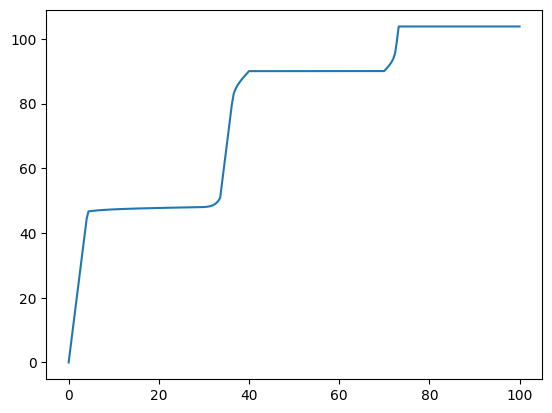

In [13]:
plt.plot(times, lengths)
plt.show()

In [15]:
for road in bus_network.roads:
    print(road.get_speed(torch.tensor(0.8), torch.tensor(0.2)))

(tensor(0.2222, grad_fn=<DivBackward0>), tensor(0.9997))
(tensor(0.2221, grad_fn=<DivBackward0>), tensor(0.9997))
(tensor(0.1667, grad_fn=<DivBackward0>), tensor(0.9997))
(tensor(0.0747, grad_fn=<DivBackward0>), tensor(0.9997))
(tensor(0.1111, grad_fn=<DivBackward0>), tensor(0.9997))
(tensor(0.2218, grad_fn=<DivBackward0>), tensor(0.9997))


In [16]:
for j in bus_network.junctions:
    print(j.get_activation(0.7, "road_3_fw", "road_4_fw"))

(False, 0.0)
(True, tensor(1.2697e-15))
(False, 0.0)


In [5]:
densities = load.convert_from_tensor(densities)
queues = load.convert_from_tensor(queues)
bus_lengths = load.convert_from_tensor(bus_lengths)
bus_delay_dict = {i : [float(l.detach()) for l in delays[i]] for i in range(len(delays))}

In [6]:
import json
with open("../results/test_bus_stopping.json", 'w') as fd:
    fd.write(json.dumps([densities, queues, bus_lengths, bus_delay_dict]))